In [1]:
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
def testar_gpu():
    import torch

    disponivel = torch.cuda.is_available()
    if not disponivel:
        print("gpu nao disponivel")
        return False, None

    nome = torch.cuda.get_device_name(0)
    print("gpu disponivel:", nome)
    return True, nome


def carga_gpu():
    import torch
    import time

    device = torch.device("cuda")

    a = torch.randn((4000, 4000), device=device)
    b = torch.randn((4000, 4000), device=device)

    inicio = time.time()
    c = torch.matmul(a, b)
    torch.cuda.synchronize()
    fim = time.time()

    tempo = fim - inicio
    print("tempo gpu:", tempo)
    return tempo


def obter_device():
    import torch

    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")


def info_device():
    import torch

    device = obter_device()
    print("device:", device)

    if device.type == "cuda":
        print("gpu:", torch.cuda.get_device_name(0))
        print("cuda:", torch.version.cuda)

    return device



testar_gpu()

carga_gpu()

obter_device()

info_device()

gpu disponivel: NVIDIA GeForce RTX 4060
tempo gpu: 0.03285503387451172
device: cuda
gpu: NVIDIA GeForce RTX 4060
cuda: 12.1


device(type='cuda')

In [39]:
def carregar_dados():
    caminho = "C:/Users/MASTER/Documents/victor/predictive_maintenance/Predictive Maintenance Dataset/ai4i2020.csv"
    data = pd.read_csv(caminho)
    return data

data = carregar_dados()


In [31]:
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [40]:
len(data.columns)


14

In [41]:
data.columns.tolist()

['UDI',
 'Product ID',
 'Type',
 'Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Machine failure',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF']

## Colunas

'UDI' -> identificador único que varia de 1 a 10.000

'Product ID' -> consiste em uma letra L, M ou H para baixo (50% de todos os produtos), médio (30%) e alto (20%) como variantes de qualidade do produto e um número de série específico da variante

'Type' -> tipo: apenas o tipo de produto L, M ou H da coluna 2

'Air temperature [K]' -> temperatura do ar [K]: gerada usando um processo de caminhada aleatória posteriormente normalizado para um desvio padrão de 2 K em torno de 300 K

'Process temperature [K]' -> temperatura do processo [K]: gerada usando um processo de caminhada aleatória normalizado para um desvio padrão de 1 K, adicionado à temperatura do ar mais 10 K

'Rotational speed [rpm]' -> velocidade de rotação [rpm]: calculada a partir de uma potência de 2860 W, sobreposta a um ruído normalmente distribuído

'Torque [Nm]' -> torque [Nm]: os valores de torque são normalmente distribuídos em torno de 40 Nm com DP = 10 Nm e sem valores negativos

'Tool wear [min]' -> desgaste da ferramenta [min]: As variantes de qualidade H/M/L adicionam 5/3/2 minutos de desgaste da ferramenta à ferramenta usada no processo

'Machine failure' -> um rótulo de 'falha da máquina' que indica se a máquina falhou neste ponto de dados específico para qualquer um dos seguintes modos de falha é verdadeiro

FALHAS

Cinco modos de falha independentes

'TWF' -> falha por desgaste da ferramenta (TWF): a ferramenta será substituída por falha em um tempo de desgaste da ferramenta selecionado aleatoriamente entre 200 e 240 minutos (120 vezes em nosso conjunto de dados). Neste momento, a ferramenta é substituída 69 vezes e falha 51 vezes (atribuída aleatoriamente)

'HDF' -> falha de dissipação de calor (HDF): a dissipação de calor causa uma falha no processo, se a diferença entre a temperatura do ar e do processo for inferior a 8,6 K e a velocidade de rotação das ferramentas for inferior a 1380 rpm. Este é o caso de 115 pontos de dados

'PWF' -> falha de energia (PWF): o produto do torque e da velocidade de rotação (em rad/s) é igual à potência necessária para o processo. Se esta potência estiver abaixo de 3500 W ou acima de 9000 W, o processo falha, o que é o caso 95 vezes em nosso conjunto de dados

'OSF' -> falha por sobretensão (OSF): se o produto do desgaste e torque da ferramenta exceder 11.000 minNm para a variante do produto L (12.000 M, 13.000 H), o processo falha devido à sobretensão. Isto é verdade para 98 pontos de dados

'RNF' -> falhas aleatórias (RNF): cada processo tem uma chance de 0,1% de falhar, independentemente dos parâmetros do processo. Este é o caso de apenas 5 pontos de dados, menos do que seria esperado para 10.000 pontos de dados em nosso conjunto de dados. Se pelo menos um dos modos de falha acima for verdadeiro, o processo falha e o rótulo 'falha da máquina' é definido como 1. Portanto, não é transparente para o método de aprendizado de máquina qual dos modos de falha causou a falha do processo


## Padrões

- Diferença de temperatura

process temperature - air temperature

- Potência mecânica

power = torque * rotational_speed_rads

rotational_speed_rads = 2 * pi * rotational_speed_rpm / 60

- Tensão na ferramenta

tool_stress = torque * tool_wear


In [34]:
data['Machine failure'].unique()


array([0, 1])

In [35]:
data['Machine failure'].value_counts()


Machine failure
0    9661
1     339
Name: count, dtype: int64

#### Não vão ser úteis no treinamento

['UDI', 'Product ID'] 

#### Codificar variáveis categóricas

Usar one-hot

['Type'] 

#### Escalar dados numéricos

Usar StandardScaler

[
 'Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]'
]


#### Balancear o dataset 

Critério -> 'Machine failure'


In [36]:
data.columns.to_list()

['UDI',
 'Product ID',
 'Type',
 'Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Machine failure',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF']

In [42]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data.columns = data.columns.str.strip()

# remover colunas desnecessárias
data = data.drop(columns=['UDI', 'Product ID'])

# transformar categórica em one-hot
data = pd.get_dummies(data, columns=['Type'], drop_first=False)

# separar features e target
x = data.drop(columns=['Machine failure'])
y = data['Machine failure']

# normalizar features numéricas
num_cols = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]

scaler = StandardScaler()
x[num_cols] = scaler.fit_transform(x[num_cols])

# dividir dataset
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.3, random_state=42, stratify=y
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


In [43]:
# visualizar primeiras linhas
print(data.head())

# visualizar informações gerais do dataset
print("\nInformações do dataset:")
print(data.info())

# estatísticas das colunas numéricas
print("\nEstatísticas descritivas:")
print(data.describe())

# verificar valores únicos por coluna
print("\nValores únicos por coluna:")
for col in data.columns:
    print(col, "->", data[col].unique()[:10])  # mostra apenas os 10 primeiros

# verificar quantas linhas e colunas existem
print("\nFormato do dataset (linhas, colunas):")
print(data.shape)

# verificar distribuição da variável alvo
print("\nDistribuição da coluna Machine failure:")
print(data['Machine failure'].value_counts())

   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF  \
0         42.8                0                0    0    0    0    0    0   
1         46.3                3                0    0    0    0    0    0   
2         49.4                5                0    0    0    0    0    0   
3         39.5                7                0    0    0    0    0    0   
4         40.0                9                0    0    0    0    0    0   

   Type_H  Type_L  Type_M  
0   False   False    True  
1   False    True   False  
2 

In [45]:
import torch
import numpy as np

# converter labels para numpy
y_train_np = y_train.to_numpy()

# contar classes
unique, counts = np.unique(y_train_np, return_counts=True)
class_counts = dict(zip(unique, counts))

# calcular pesos inversamente proporcionais
class_weights = [1/class_counts[0], 1/class_counts[1]]
class_weights = torch.tensor(class_weights, dtype=torch.float32).cuda()

print("pesos das classes:", class_weights)


pesos das classes: tensor([0.0001, 0.0042], device='cuda:0')


In [47]:
# checar tipos de dados
print(x_train.dtypes)

# listar todas as colunas que ainda não são numéricas
cols_obj = x_train.select_dtypes(include=['object']).columns
print("colunas com problema:", cols_obj.tolist())


Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]     float64
Torque [Nm]                float64
Tool wear [min]            float64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
Type_H                        bool
Type_L                        bool
Type_M                        bool
dtype: object
colunas com problema: []


In [48]:
# converter colunas booleanas para int
bool_cols = ['Type_H', 'Type_L', 'Type_M']
x_train[bool_cols] = x_train[bool_cols].astype(int)
x_val[bool_cols]   = x_val[bool_cols].astype(int)
x_test[bool_cols]  = x_test[bool_cols].astype(int)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# converter para tensores
x_train_t = torch.tensor(x_train.values, dtype=torch.float32).cuda()
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).cuda()

x_val_t = torch.tensor(x_val.values, dtype=torch.float32).cuda()
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).cuda()

x_test_t = torch.tensor(x_test.values, dtype=torch.float32).cuda()
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).cuda()

batch_size = 256
train_loader = DataLoader(TensorDataset(x_train_t, y_train_t), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(x_val_t, y_val_t), batch_size=batch_size)

# calcular pos_weight para BCEWithLogitsLoss
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).cuda()
print("pos_weight =", pos_weight)

class Modelo(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)     # sem sigmoid
        )

    def forward(self, x):
        return self.net(x)

model = Modelo(x_train.shape[1]).cuda()

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50

history_epochs = []
history_train_loss = []
history_val_loss = []
history_train_acc = []
history_val_acc = []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0
    correct = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()

        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

        preds = torch.sigmoid(logits)
        preds_bin = (preds > 0.5).float()
        correct += (preds_bin == yb).sum().item()

    train_loss = total_loss / len(x_train_t)
    train_acc = correct / len(x_train_t)

    # validação
    model.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)

            preds = torch.sigmoid(logits)
            preds_bin = (preds > 0.5).float()
            correct += (preds_bin == yb).sum().item()

    val_loss /= len(x_val_t)
    val_acc = correct / len(x_val_t)

    history_epochs.append(epoch)
    history_train_loss.append(train_loss)
    history_val_loss.append(val_loss)
    history_train_acc.append(train_acc)
    history_val_acc.append(val_acc)

    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} // Train Acc: {train_acc:.4f} "
          f"// Val Loss: {val_loss:.4f} // Val Acc: {val_acc:.4f}")

# salvar modelo
torch.save(model.state_dict(), "modelo_treinado_sem_smote.pth")

# salvar histórico
historico = pd.DataFrame({
    "epoch": history_epochs,
    "train_loss": history_train_loss,
    "train_acc": history_train_acc,
    "val_loss": history_val_loss,
    "val_acc": history_val_acc
})
historico.to_csv("historico_treinamento.csv", index=False)

print("modelo salvo em modelo_treinado.pth")
print("histórico salvo em historico_treinamento.csv")

# avaliação final
model.eval()
with torch.no_grad():
    logits = model(x_test_t)
    preds = torch.sigmoid(logits)
    preds_bin = (preds > 0.5).float()

print("\n===== classification report =====")
print(classification_report(y_test_t.cpu(), preds_bin.cpu()))


print("\n===== matriz de confusão =====")
print(confusion_matrix(y_test_t.cpu(), preds_bin.cpu()))


pos_weight = tensor([28.5359], device='cuda:0')
Epoch 001 | Train Loss: 1.1281 // Train Acc: 0.6904 // Val Loss: 0.8199 // Val Acc: 0.7967
Epoch 002 | Train Loss: 0.5960 // Train Acc: 0.8851 // Val Loss: 0.3838 // Val Acc: 0.9413
Epoch 003 | Train Loss: 0.3214 // Train Acc: 0.9477 // Val Loss: 0.2273 // Val Acc: 0.9867
Epoch 004 | Train Loss: 0.2426 // Train Acc: 0.9736 // Val Loss: 0.1829 // Val Acc: 0.9900
Epoch 005 | Train Loss: 0.1793 // Train Acc: 0.9864 // Val Loss: 0.2191 // Val Acc: 0.9747
Epoch 006 | Train Loss: 0.1791 // Train Acc: 0.9866 // Val Loss: 0.1752 // Val Acc: 0.9987
Epoch 007 | Train Loss: 0.1547 // Train Acc: 0.9887 // Val Loss: 0.1863 // Val Acc: 0.9973
Epoch 008 | Train Loss: 0.1460 // Train Acc: 0.9924 // Val Loss: 0.1789 // Val Acc: 0.9980
Epoch 009 | Train Loss: 0.1231 // Train Acc: 0.9953 // Val Loss: 0.1907 // Val Acc: 0.9980
Epoch 010 | Train Loss: 0.1292 // Train Acc: 0.9941 // Val Loss: 0.1922 // Val Acc: 0.9987
Epoch 011 | Train Loss: 0.1220 // Train Ac

In [64]:
caminho = r"C:\Users\MASTER\Documents\victor\predictive_maintenance\historico_treinamento.csv"
training_history = pd.read_csv(caminho)


In [65]:
training_history

,epoch,train_loss,train_acc,val_loss,val_acc
0,1,1.132902,0.478286,0.776597,0.831333
1,2,0.580923,0.870429,0.432243,0.965333
2,3,0.336618,0.942000,0.232655,0.952000
3,4,0.225484,0.976286,0.193808,0.995333
4,5,0.179356,0.987000,0.187592,0.997333
5,6,0.171359,0.988857,0.188697,0.998000
6,7,0.150780,0.991286,0.194547,0.998000
7,8,0.140355,0.993857,0.193808,0.998000
8,9,0.123828,0.995000,0.204932,0.998000
9,10,0.149574,0.992000,0.200797,0.998000


Index(['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'], dtype='object')


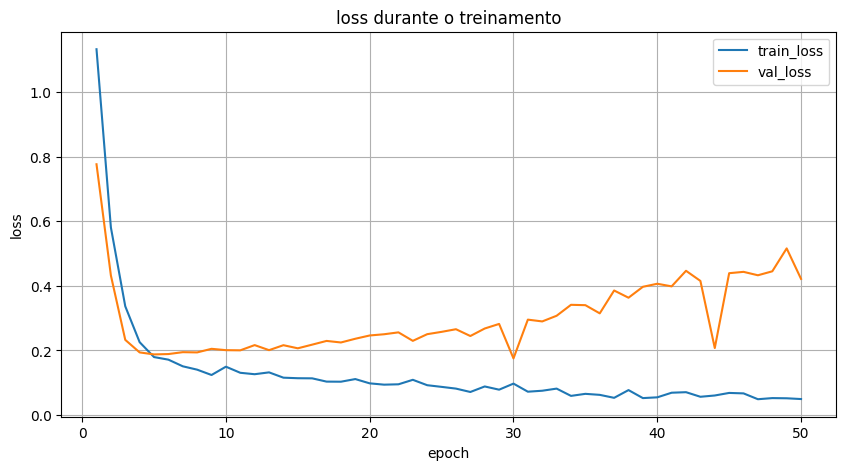

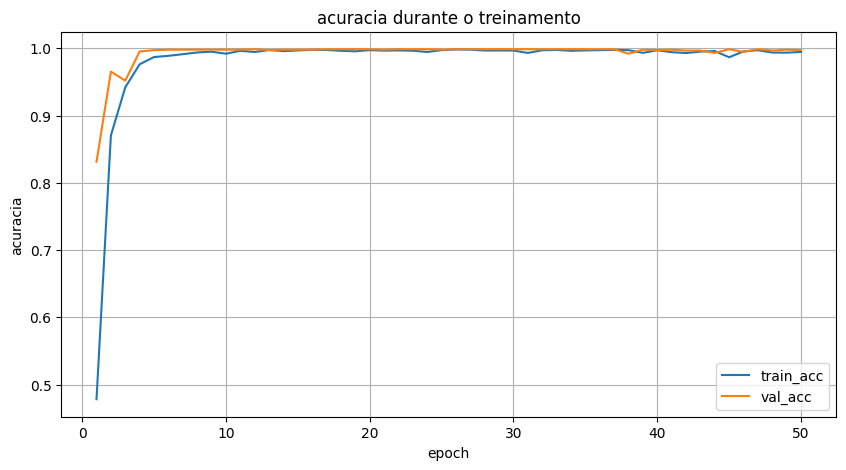


===== classification report =====
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1449
         1.0       0.94      1.00      0.97        51

    accuracy                           1.00      1500
   macro avg       0.97      1.00      0.99      1500
weighted avg       1.00      1.00      1.00      1500



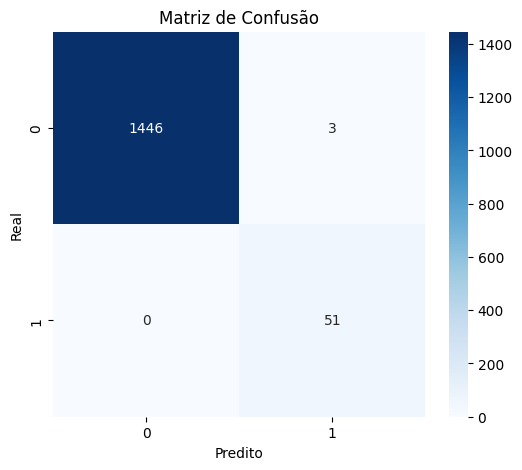

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# carregar o histórico do treinamento
training_history = pd.read_csv("teste1-historico_treinamento.csv")

print(training_history.columns)

# gráfico de loss
plt.figure(figsize=(10,5))
plt.plot(training_history['epoch'], training_history['train_loss'], label='train_loss')
plt.plot(training_history['epoch'], training_history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss durante o treinamento')
plt.legend()
plt.grid(True)
plt.show()

# gráfico de acurácia
plt.figure(figsize=(10,5))
plt.plot(training_history['epoch'], training_history['train_acc'], label='train_acc')
plt.plot(training_history['epoch'], training_history['val_acc'], label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acuracia')
plt.title('acuracia durante o treinamento')
plt.legend()
plt.grid(True)
plt.show()

# métricas finais
print("\n===== classification report =====")
print(classification_report(y_test_t.cpu(), preds_bin.cpu()))

# matriz de confusão (gráfico)
cm = confusion_matrix(y_test_t.cpu(), preds_bin.cpu())

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


## Teste 2

pos_weight = tensor([28.5359], device='cuda:0')
Epoch 001 | Train Loss: 1.3573 // Train Acc: 0.0339 // Val Loss: 1.3396 // Val Acc: 0.0340
Epoch 002 | Train Loss: 1.3293 // Train Acc: 0.0354 // Val Loss: 1.3021 // Val Acc: 0.0340
Epoch 003 | Train Loss: 1.2941 // Train Acc: 0.0919 // Val Loss: 1.2415 // Val Acc: 0.1020
Epoch 004 | Train Loss: 1.2320 // Train Acc: 0.3070 // Val Loss: 1.1481 // Val Acc: 0.6773
Epoch 005 | Train Loss: 1.1448 // Train Acc: 0.5360 // Val Loss: 1.0219 // Val Acc: 0.7773
Epoch 006 | Train Loss: 1.0227 // Train Acc: 0.6954 // Val Loss: 0.8817 // Val Acc: 0.8347
Epoch 007 | Train Loss: 0.9353 // Train Acc: 0.8030 // Val Loss: 0.7512 // Val Acc: 0.8767
Epoch 008 | Train Loss: 0.8208 // Train Acc: 0.8176 // Val Loss: 0.6371 // Val Acc: 0.8940
Epoch 009 | Train Loss: 0.7738 // Train Acc: 0.8534 // Val Loss: 0.5454 // Val Acc: 0.9240
Epoch 010 | Train Loss: 0.6781 // Train Acc: 0.8787 // Val Loss: 0.4791 // Val Acc: 0.9547
Epoch 011 | Train Loss: 0.5893 // Train Ac

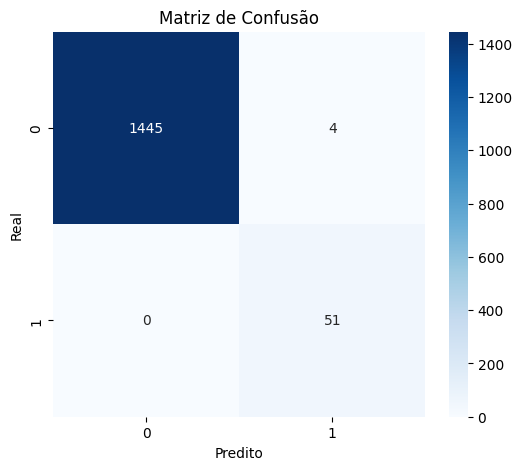

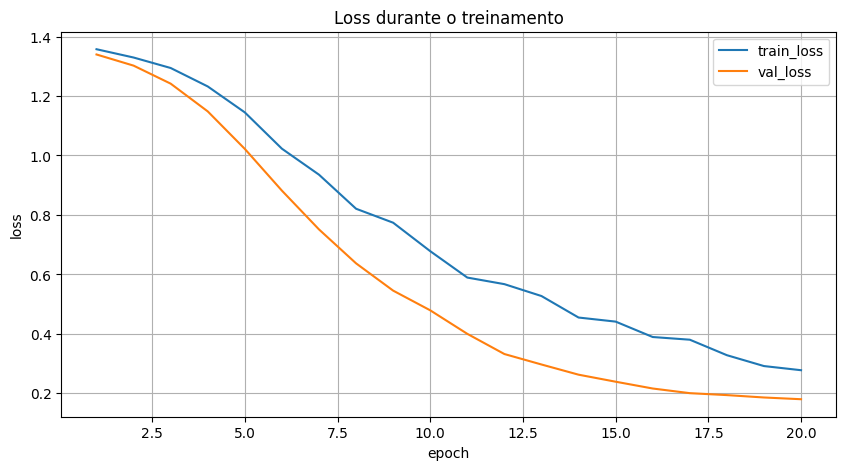

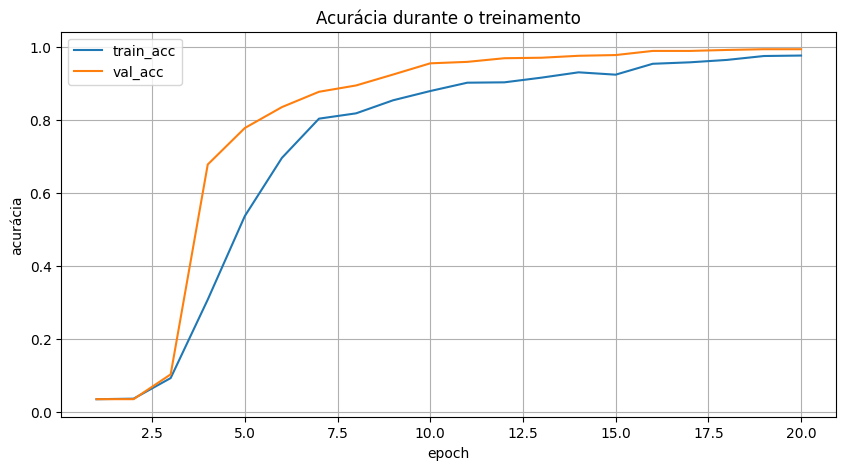

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# converter para tensores
x_train_t = torch.tensor(x_train.values, dtype=torch.float32).cuda()
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).cuda()

x_val_t = torch.tensor(x_val.values, dtype=torch.float32).cuda()
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).cuda()

x_test_t = torch.tensor(x_test.values, dtype=torch.float32).cuda()
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).cuda()

batch_size = 256
train_loader = DataLoader(TensorDataset(x_train_t, y_train_t), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(x_val_t, y_val_t), batch_size=batch_size)

# pesos para BCEWithLogitsLoss
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).cuda()
print("pos_weight =", pos_weight)


# modelo otimizado
class Modelo(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(16, 8),
            nn.ReLU(),

            nn.Linear(8, 1)   
        )

    def forward(self, x):
        return self.net(x)


model = Modelo(x_train.shape[1]).cuda()

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  

epochs = 20
patience = 5
best_val_loss = float("inf")
early_stop_counter = 0

history_epochs = []
history_train_loss = []
history_val_loss = []
history_train_acc = []
history_val_acc = []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0
    correct = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = torch.sigmoid(logits)
        preds_bin = (preds > 0.5).float()
        correct += (preds_bin == yb).sum().item()

    train_loss = total_loss / len(x_train_t)
    train_acc = correct / len(x_train_t)

    model.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)

            preds = torch.sigmoid(logits)
            preds_bin = (preds > 0.5).float()
            correct += (preds_bin == yb).sum().item()

    val_loss /= len(x_val_t)
    val_acc = correct / len(x_val_t)

    history_epochs.append(epoch)
    history_train_loss.append(train_loss)
    history_val_loss.append(val_loss)
    history_train_acc.append(train_acc)
    history_val_acc.append(val_acc)

    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} // Train Acc: {train_acc:.4f} "
          f"// Val Loss: {val_loss:.4f} // Val Acc: {val_acc:.4f}")

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "modelo_treinado.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("\nEarly stopping ativado!")
            break


# salvar histórico
historico = pd.DataFrame({
    "epoch": history_epochs,
    "train_loss": history_train_loss,
    "train_acc": history_train_acc,
    "val_loss": history_val_loss,
    "val_acc": history_val_acc
})
historico.to_csv("historico_treinamento.csv", index=False)

print("\nModelo salvo como modelo_treinado.pth")
print("Histórico salvo como historico_treinamento.csv")


# avaliação final
model.eval()
with torch.no_grad():
    logits = model(x_test_t)
    preds = torch.sigmoid(logits)
    preds_bin = (preds > 0.5).float()

print("\n===== classification report =====")
print(classification_report(y_test_t.cpu(), preds_bin.cpu()))



from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

# métricas por classe
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_t.cpu(), preds_bin.cpu(), labels=[0,1]
)

tabela_metricas = pd.DataFrame({
    "precision": precision,
    "recall": recall,
    "f1-score": f1,
    "support": support
}, index=["classe 0", "classe 1"])

print("\n===== Métricas por classe =====\n")
print(tabela_metricas)




# gráfico matriz de confusão
cm = confusion_matrix(y_test_t.cpu(), preds_bin.cpu())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


# gráfico de loss
plt.figure(figsize=(10,5))
plt.plot(history_epochs, history_train_loss, label="train_loss")
plt.plot(history_epochs, history_val_loss, label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss durante o treinamento")
plt.grid(True)
plt.legend()
plt.show()

# gráfico de acurácia
plt.figure(figsize=(10,5))
plt.plot(history_epochs, history_train_acc, label="train_acc")
plt.plot(history_epochs, history_val_acc, label="val_acc")
plt.xlabel("epoch")
plt.ylabel("acurácia")
plt.title("Acurácia durante o treinamento")
plt.grid(True)
plt.legend()
plt.show()
